Load packages

In [109]:
import os
# supress tensorflow logging other than errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn import ModeKeys, Estimator

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

/home/fqaiser94/.local/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [8]:
sess = tf.InteractiveSession()

load data 

In [21]:
# first we have to get our data
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz


Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [86]:
dir(mnist)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_asdict',
 '_fields',
 '_make',
 '_replace',
 '_source',
 'count',
 'index',
 'test',
 'train',
 'validation']

In [87]:
dir(mnist.train)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_epochs_completed',
 '_images',
 '_index_in_epoch',
 '_labels',
 '_num_examples',
 'epochs_completed',
 'images',
 'labels',
 'next_batch',
 'num_examples']

Let's try to understand what the images object is. 

In [98]:
mnist.train.images

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

images is a tensor (i.e an n-dimensional array). The tensor has a shape as follows.   

In [99]:
mnist.train.images.shape

(55000, 784)

The first dimension indicate the number of images while the second dimension indicates the  number of pixels in each image.  

Each entry in the tensor is the pixel intensity between 0 and 1, for a particular pixel in a particular image.  

Now let's look at the labels object. 

In [120]:
mnist.train.labels

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

another tensor, no surpise. Let's have a look at its dimensions.  

In [122]:
mnist.train.labels.shape

(55000, 10)

Again, the first dimension (i.e. each row) corresponds to the index of an image. The second dimension indicates the that we have 10 data points (i.e. columns) for each image. These 10 data points are essentially a categorical encoding of the class (or label) of each image (0-9). 

Let's see if we can visualize one of these images and its corresponding label. 

In [116]:
def display_digit(tensor, index):
    
    image = (tensor
             .images[index]
             .reshape([50,50])
             )
    
    label = (tensor
             .labels[index]
             .tolist()
             .index(1)
             )
    
    print('Showing an image of the number %s' % label)
    
    plt.imshow(image, 
               cmap = plt.get_cmap('gray_r'))
    
    plt.show()
    
    plt.savefig('fig.png')

Showing an image of the number 2


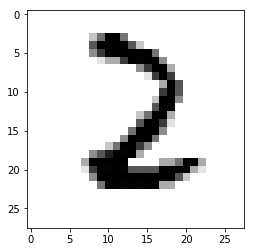

In [114]:
display_digit(tensor=mnist.train, 
              index=np.random.randint(low=0,
                                      high=mnist.train.num_examples)
              )

Excellent, so we have some intuition for our data now.  

As you can see, the images aren't "perfect" which makes sense since these are supposed to be hand-drawn digits.  

Now, let's try building a deep learning model to predict the class of an image.   

In [124]:
# We start building the computation graph 
# by creating nodes for the input images and 
# target output classes.

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

# The input images x will consist of a 2d tensor 
# of floating point numbers. 
# Here we assign it a shape of [None, 784], 
# where 784 is the dimensionality of 
# a single flattened 28 by 28 pixel MNIST image, 
# and None indicates that the first dimension, 
# corresponding to the batch size, 
# can be of any size. 
# The target output classes y_ will also 
# consist of a 2d tensor, where each row is a 
# one-hot 10-dimensional vector indicating which 
# digit class (zero through nine) the corresponding 
# MNIST image belongs to.

# The shape argument to placeholder is optional, 
# but it allows TensorFlow to automatically catch bugs 
# stemming from inconsistent tensor shapes.

In [125]:
# We now define the weights W and biases b for our model.
# We could imagine treating these like additional inputs,
# but TensorFlow has an even better way to handle them: 
# Variable. 
# A Variable is a value that lives in 
# TensorFlow's computation graph. 
# It can be used and even modified by the computation. 
# In machine learning applications, 
# one generally has the model parameters be Variables.

W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

# We pass the initial value for each parameter in the 
# call to tf.Variable. 
# In this case, we initialize both W and b as tensors 
# full of zeros. W is a 784x10 matrix (because we 
# have 784 input features and 10 outputs) and b 
# is a 10-dimensional vector (because we have 10 
# classes).

In [126]:
# Before Variables can be used within a session, 
# they must be initialized using that session. 
# This step takes the initial values 
# (in this case tensors full of zeros) that have 
# already been specified, and assigns them to each 
# Variable. This can be done for all Variables at once:

sess.run(tf.global_variables_initializer())

In [127]:
# We can now implement our regression model. 
# It only takes one line! 
# We multiply the vectorized input images x by 
# the weight matrix W, add the bias b.

y = tf.matmul(x,W) + b

In [128]:
# We can specify a loss function just as easily. 
# Loss indicates how bad the model's prediction was 
# on a single example; we try to minimize that while 
# training across all the examples. Here, our loss 
# function is the cross-entropy between the target 
# and the softmax activation function applied to 
# the model's prediction. As in the beginners tutorial, 
# we use the stable formulation:

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

# Note that tf.nn.softmax_cross_entropy_with_logits 
# internally applies the softmax on the model's 
# unnormalized model prediction and sums across all 
# classes, and tf.reduce_mean takes the average over 
# these sums.

Now that we've built a model, let's train it

In [129]:
# Now that we have defined our model and training loss 
# function, it is straightforward to train using 
# TensorFlow. Because TensorFlow knows the entire 
# computation graph, it can use automatic differentiation 
# to find the gradients of the loss with respect to each 
# of the variables. TensorFlow has a variety of 
# built-in optimization algorithms. For this example, 
# we will use steepest gradient descent, with a step 
# length of 0.5, to descend the cross entropy.

train_step = (tf
              .train
              .GradientDescentOptimizer(0.5)
              .minimize(cross_entropy)
              )

# What TensorFlow actually did in that single line was 
# to add new operations to the computation graph. These 
# operations included ones to compute gradients, compute 
# parameter update steps, and apply update steps to the 
# parameters.

In [130]:
# The returned operation train_step, when run, 
# will apply the gradient descent updates to the 
# parameters. Training the model can therefore be 
# accomplished by repeatedly running train_step.

for _ in range(1000):
  batch = mnist.train.next_batch(100)
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})
  
# We load 100 training examples in each training 
# iteration. We then run the train_step operation, 
# using feed_dict to replace the placeholder tensors 
# x and y_ with the training examples. Note that you 
# can replace any tensor in your computation graph 
# using feed_dict -- it's not restricted to just 
# placeholders.

Now let's evaluate our model. 

In [132]:
# First we'll figure out where we predicted the correct 
# label. tf.argmax is an extremely useful function which 
# gives you the index of the highest entry in a tensor 
# along some axis. For example, tf.argmax(y,1) is the 
# label our model thinks is most likely for each input, 
# while tf.argmax(y_,1) is the true label. We can use 
# tf.equal to check if our prediction matches the truth.

correct_prediction = tf.equal(tf.argmax(y,1), 
                              tf.argmax(y,1)
                              )

# That gives us a list of booleans. To determine what 
# fraction are correct, we cast to floating point 
# numbers and then take the mean. For example, 
# [True, False, True, True] would become [1,0,1,1] 
# which would become 0.75.

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 
                                  tf.float32))

# Finally, we can evaluate our accuracy on the test 
# data. This should be about 92% correct.

print(accuracy.eval(feed_dict={x: mnist.test.images, 
                               y_: mnist.test.labels}))


1.0


In [ ]:
# testing github integration. 